In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files= files.upload()

Saving review_fix.csv to review_fix.csv


In [3]:
df=pd.read_csv('review_fix.csv')
df.head()

,stopwords,punctuation,hastags,is_english,review,word_count,polarity,subjectivity,review_classification,SentimentScore,Sentiment
0,5,3,0,True,"['wife', 'needed', 'rain', 'jacket', 'last', '...",8,0.18,0.36,1,3.0,1
1,2,1,0,True,"['true', 'size', 'small']",3,0.05,0.52,0,2.0,1
2,6,4,0,True,"['nice', 'coat', 'sleeves', 'seems', 'long', '...",8,0.10,0.60,0,3.0,1
3,11,2,0,True,"['bought', 'alaska', 'cruise', 'worked', 'work...",12,1.00,1.00,1,3.0,1
4,3,9,0,True,"['definitely', 'first', 'rain', 'stayed', 'sec...",11,0.12,0.17,1,0.0,0


In [4]:
df['Sentiment'].unique()

array([1, 0])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stopwords              2294 non-null   int64  
 1   punctuation            2294 non-null   int64  
 2   hastags                2294 non-null   int64  
 3   is_english             2294 non-null   bool   
 4   review                 2294 non-null   object 
 5   word_count             2294 non-null   int64  
 6   polarity               2294 non-null   float64
 7   subjectivity           2294 non-null   float64
 8   review_classification  2294 non-null   int64  
 9   SentimentScore         2294 non-null   float64
 10  Sentiment              2294 non-null   int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 181.6+ KB


Good: 1748 76.2 %
Bad: 546 23.8 %


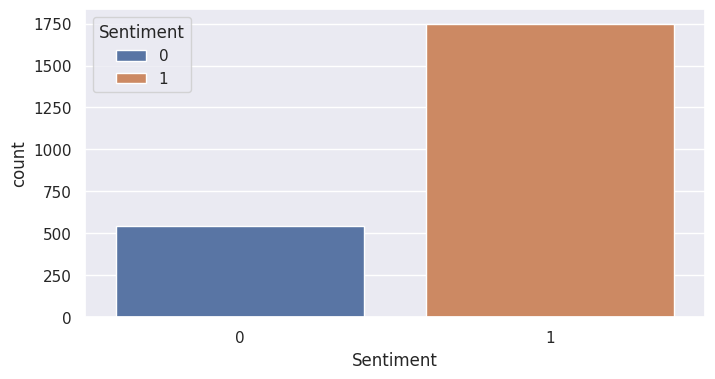

In [6]:
# Distribution of review classes
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize":(8,4)})
sns.countplot(x='Sentiment',hue=df['Sentiment'], data=df)

# Calculate class counts
Y_counts = df.groupby('Sentiment').size()

# Print class counts and percentages
total_samples = Y_counts.sum()
print('Good:', Y_counts[1], round(Y_counts[1] / total_samples * 100, 2), '%')
print('Bad:', Y_counts[0], round(Y_counts[0] / total_samples * 100, 2), '%')

Since the class (bad and good reviews) is imbalanced, we will handle the problem since it is a crucial consideration in the classification task. If not addressed, classifiers tend to be biased towards the majority class, leading to poor performance, particularly for the minority class. The class imblance will be handle using oversampleng technique, SMOTE

In [7]:
#split dataset into train and test
from sklearn.model_selection import train_test_split

y= df.Sentiment.values
X= df.review

X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size = 0.25, random_state=45)


print ('X train :', X_train.shape )
print ( 'y train :', y_train.shape)
print ('X Test :', X_test.shape )
print ( 'y Test :', y_test.shape)

X train : (1720,)
y train : (1720,)
X Test : (574,)
y Test : (574,)


Next, we will converting reviews to a matrix of TF-IDF  (Term Frequency-Inverse Document Frequency) features. This is a crucial preprocessing step in natural language processing tasks, particularly for tasks like text classification, clustering, and information retrieval. It helps in extracting meaningful information from text data and facilitates downstream analysis and modeling.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfi = TfidfVectorizer(ngram_range=(1,3), max_features = 2000)

X_train_tfi = tfi.fit_transform(X_train).toarray()
X_test_tfi = tfi.transform(X_test).toarray()

In [9]:
# Over sampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train_tfi, y_train.ravel())

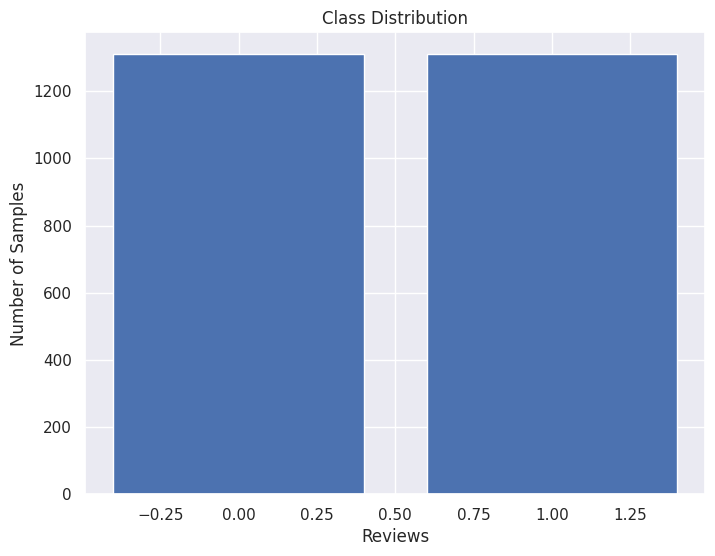

In [10]:
class_counts = dict(zip(*np.unique(y_train, return_counts=True)))

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Reviews')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

plt.show()

**Predictive Modeling**

In this project, I will use 3 different algorithms such as: Multinomial Naive Bayes (MultinomialNB), Logistic Regression and LSTM (Long Short Term Memory)

In [11]:
dfResults = pd.DataFrame(columns=['Model','Accuracy', 'Precision','Recall','F1 score','Confusion matrix'])
dfResults

,Model,Accuracy,Precision,Recall,F1 score,Confusion matrix


In [12]:
# save the model evaluation in dataframe
def SaveResults(modelname, accuracy, precision, recall, F1_score, confusion_matrix):
  global dfResults
  dfResults.style.hide_index()
  if(dfResults[dfResults['Model']==modelname] is not np.empty):
    dfResults.drop(dfResults.loc[dfResults['Model']==modelname].index, inplace=True)
  new_results = {'Model': modelname,
             'Accuracy': accuracy,
             'Precision':precision,
             'Recall':recall,
             'F1 score':F1_score,
             'Confusion matrix':confusion_matrix}
  #append row to the dataframe
  dfResults= dfResults.append(new_results, ignore_index=True)


# Evaluate the model based on accuray, precision, recall, F1 and ROC score
def evaluate_model(x_test, y_true, model,modelname):
  from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_true, y_pred)
  # print('Accuracy: {:.2f}%'.format(accuracy))
  precision = precision_score(y_true, y_pred,average='weighted')
  print('Precision: {:.2f}%'.format(precision))
  recall = recall_score(y_true, y_pred, average='weighted')
  print('Recall: {:.2f}%'.format( recall))
  f1 = f1_score(y_true, y_pred,average='weighted')
  print('Accuracy: {:.2f}%'.format(accuracy))


  # confusion matrix
  matrix = confusion_matrix(y_true, y_pred)
  print("Confusion metrics \n",matrix)
  print('**********************************************************')
  print('*****************  Classification Report  ****************')
  print('**********************************************************')
  print(classification_report(y_true,y_pred))
  SaveResults(modelname,accuracy,precision,recall,f1,matrix)


**1. Multinomial Naive Bayes (MultinomialNB)**

In [13]:
from sklearn.naive_bayes import MultinomialNB

#  Instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

#  Train the model
model_nb=nb.fit(X_train, y_train)

In [14]:
# Evaluate model
evaluate_model(X_test_tfi, y_test, model_nb, 'Naive Bayes')

Precision: 0.83%
Recall: 0.82%
Accuracy: 0.82%
Confusion metrics 
 [[ 94  42]
 [ 60 378]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       136
           1       0.90      0.86      0.88       438

    accuracy                           0.82       574
   macro avg       0.76      0.78      0.76       574
weighted avg       0.83      0.82      0.83       574



The accuracy of the model is 82%, but as we can see that the f1 score for positive class is higher than negative class, which means even after handle the class imblance, the model learn to predict the positive class more accurately compared to bad review (negative class)

2. Logistic Regression

In [15]:
#  Import
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
lr_model = LogisticRegression()

# Train the model
model_lr=lr_model.fit(X_train, y_train)

In [16]:
# Evaluate model
y_pred=evaluate_model(X_test_tfi, y_test, model_lr, 'Logistic Regression')

Precision: 0.91%
Recall: 0.90%
Accuracy: 0.90%
Confusion metrics 
 [[119  17]
 [ 42 396]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       136
           1       0.96      0.90      0.93       438

    accuracy                           0.90       574
   macro avg       0.85      0.89      0.87       574
weighted avg       0.91      0.90      0.90       574



In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
cv_logreg= logreg.fit(X_train, y_train)

# predicting test set results
y_pred = logreg.predict(X_test_tfi)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.90
Precision score: 0.96
Recall score: 0.90
F1 score: 0.90


The model have accuracy of 90%

**3. Complement Naive Bayes**

In [19]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix

classifier_CNB = ComplementNB()
cv_CNB= classifier_CNB.fit(X_train, y_train) # This will be used later for model comparison


In [20]:
# Evaluate model
evaluate_model(X_test_tfi, y_test, cv_CNB, 'Complement Naive Bayes')

Precision: 0.83%
Recall: 0.82%
Accuracy: 0.82%
Confusion metrics 
 [[ 94  42]
 [ 60 378]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       136
           1       0.90      0.86      0.88       438

    accuracy                           0.82       574
   macro avg       0.76      0.78      0.76       574
weighted avg       0.83      0.82      0.83       574



**Receiver Operating Characteristic (ROC)**

In [81]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [82]:
# Get predicted probabilities for each classifiers from fitted classifiers
y_score1 = model_nb.predict_proba(X_test_tfi)[:,1]
y_score2 = model_lr.predict_proba(X_test_tfi)[:,1]
y_score3 = cv_CNB.predict_proba(X_test_tfi)[:,1]

# Plot Receiving Operating Characteristic Curve
  # Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)


print('roc_auc_score for  Multinominal NB: {0:0.2f}'.format (roc_auc_score(y_test, y_score1)))
print('roc_auc_score for Logistic Regression: {0:0.2f}'.format (roc_auc_score(y_test, y_score2)))
print('roc_auc_score for Complement NB: {0:0.2f}'.format (roc_auc_score(y_test, y_score3)))



roc_auc_score for  Multinominal NB: 0.87
roc_auc_score for Logistic Regression: 0.95
roc_auc_score for Complement NB: 0.87


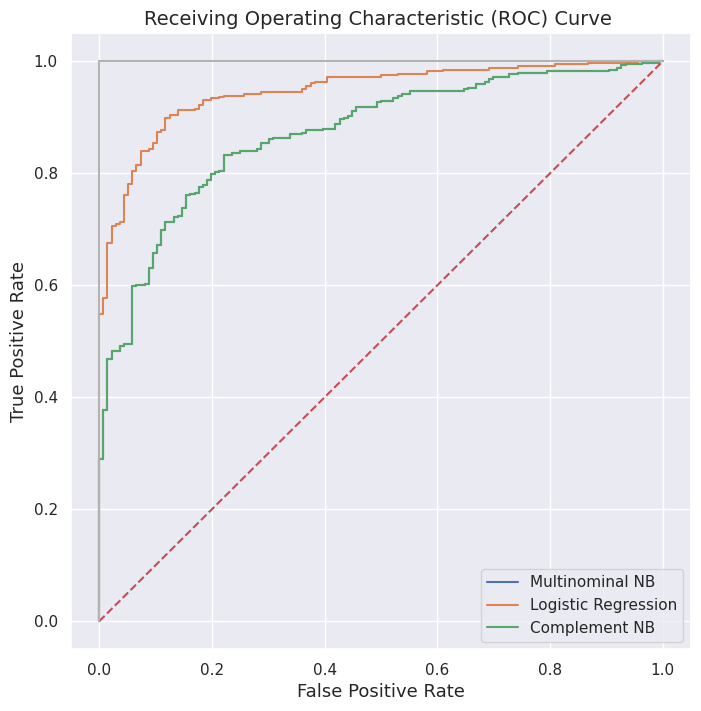

In [83]:
sns.set(style="darkgrid", color_codes=True)
plt.figure(figsize= (8,8))
plt.plot(false_positive_rate1, true_positive_rate1, label="Multinominal NB")
plt.plot(false_positive_rate2, true_positive_rate2, label="Logistic Regression")
plt.plot(false_positive_rate3, true_positive_rate3, label="Complement NB")

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize= 13)
plt.xlabel('False Positive Rate', fontsize= 13)
plt.title('Receiving Operating Characteristic (ROC) Curve ', fontsize= 14)
plt.legend()
plt.show()

In [84]:
#Keep in mind that y_test is now defined for Logisctic Regression which is the best model according to model according to model comparison.
predictions = y_pred

testing_predictions = []
for i in range(len(X_test)):
       if predictions[i] == 1:
        testing_predictions.append(1)
       else:
        testing_predictions.append(0)

check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'review':list(X_test)})
check_df.head()
#Keep in mind that y_test is now defined for Logisctic Regression which is the best model according to model.


,actual_label,prediction,review
0,0,0,"['whenever', 'send', 'away', 'clothing', 'alwa..."
1,1,1,"['start', 'never', 'ordered', 'apple', 'macboo..."
2,1,0,"['jacket', 'fits', 'husband', 'however', 'jack..."
3,1,1,"['like', 'marmot', 'brand', 'wanted', 'love', ..."
4,0,1,"['normally', 'wear', 'large', 'extra', 'large'..."
